# Implementing ANNs with TensorFlow - Homework 02

## Assignment: MNIST classification

### Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

### Loading the dataset

In [2]:
# Load the data
(train_ds, test_ds), ds_info = tfds.load ('mnist', split =['train', 'test'], as_supervised = True, with_info = True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


**How many training/test images are there?**

> There are 10000 images in the 'test' data set, while there are 60000 images in the 'train' data set.

**What's the image shape?**

> The images are formatted in 28x28 pixels in greyscale, therefore the shape is (28, 28, 1).

**What range are pixel values in?**

> Pixel values range from 0 (white) to 255 (black). Therefore, lower numbers indicate lightness, and higher numbers indicate darkness.

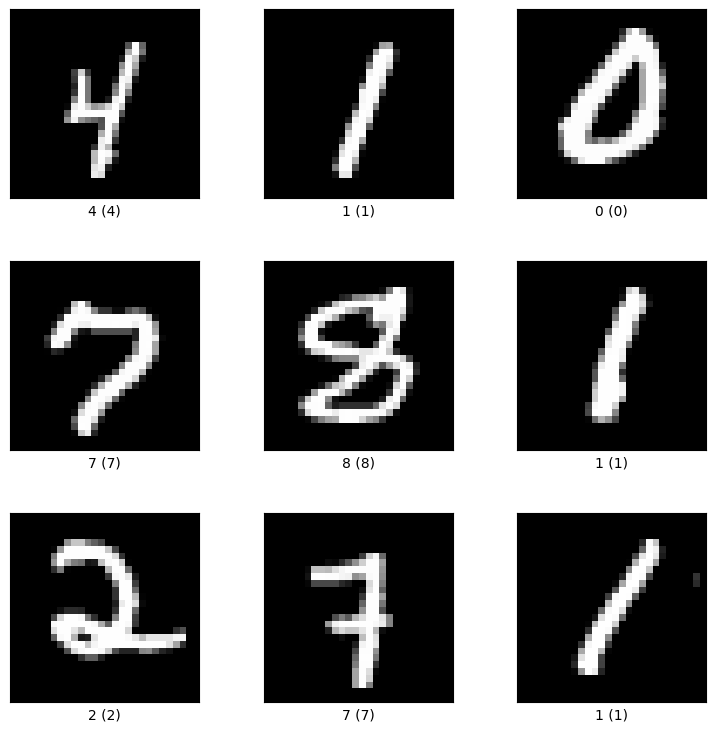

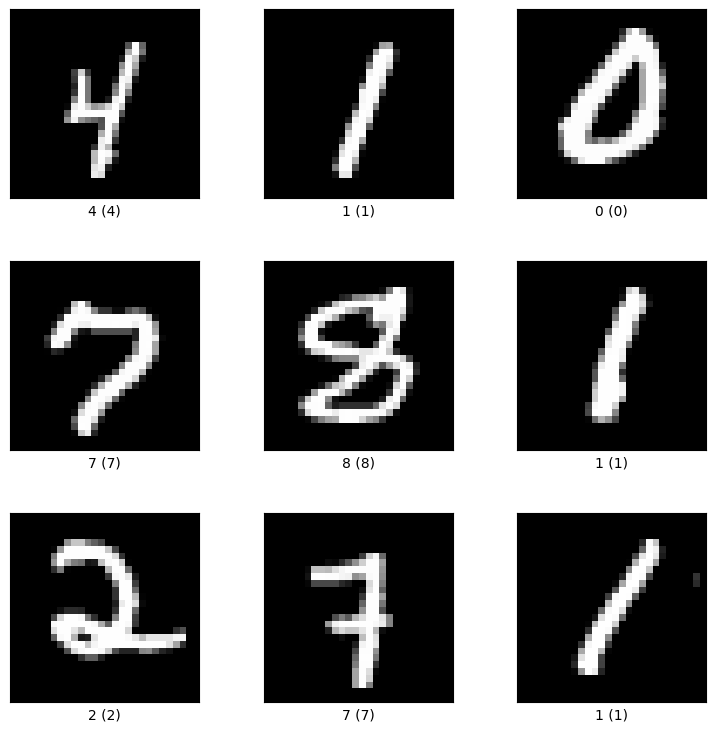

In [3]:
# Show some example images
tfds.show_examples(train_ds, ds_info)

### Setting up the data pipeline

In [ ]:
def prepare_data(mnist, batch_size=32):
    """
    This function is used to prepare the raw data for training and testing.

    Arguments:
    mnist -- (A subset of) the MNIST dataset
    batch_size -- Denotes the batch size (default is 32)
    """
    # Flatten the images into vectors
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    # Convert images to float32 data type
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Project the pixel values into range [-1, 1]
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    # Represent targets as one-hot vectors
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # Cache progress into memory
    mnist = mnist.cache()
    # Shuffle, batch & prefetch the data
    mnist = mnist.shuffle(1000)
    mnist = mnist.batch(batch_size)
    mnist = mnist.prefetch(batch_size)

    return mnist

In [ ]:
# Preprocess the training and test datasets
train_dataset = train_ds.apply(prepare_data)
test_dataset = test_ds.apply(prepare_data)

### Building the model

In [ ]:
class MnistModel(tf.keras.Model):
    """
    This subclass of the keras model builds our neural network.
    """
    def __init__ (self, n_hidden_layers=2, hidden_layer_size=256):
        """
        The constructor initiates the layers and their activation functions.
        The base model contains two hidden layers with 256 neurons each and an output layer with 10 neurons.

        Arguments:
        n_hidden_layers -- Denotes the number of hidden layers (default is 2)
        hidden_layer_size -- Denotes the number of neurons in a hidden layer (default is 256)
        """
        super().__init__()

        # Instantiate the hidden layers using ReLU as activation function
        self.hidden_layers = [tf.keras.layers.Dense(hidden_layer_size, activation=tf.nn.relu) for i in range(n_hidden_layers)]
        # Instantiate the output layer with softmax as activation function
        self.output_layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call (self, input):
        """
        This function calls the model on new input and returns the output as tensors.

        Arguments:
        input -- denotes the input tensors
        """
        output = input

        # Feed the input through the network
        for i, _ in enumerate(self.hidden_layers):
            output = self.hidden_layers[i](output)
        output = self.output_layer(output)

        return output

### Training the model

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
    """
    This function defines a step during the training process.

    Arguments:
    model -- The model object representing our neural network
    input -- The input tensors to the model
    target -- The model targets
    loss_function -- The loss function of the model
    optimizer -- The model optimizer
    """
    with tf.GradientTape() as tape:
        # Create the prediction
        prediction = model(input)
        # Calculate the loss and accuracy
        loss = loss_function(target, prediction)
        accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        accuracy = np.mean(accuracy)
    # Calculate the gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply the gradients following the optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, accuracy


def test(model, test_data, loss_function):
    """
    A function to test how the model performs on the given data.
    Returns the mean loss and accuracy.

    Arguments:
    model -- Our neural network
    test_data -- The data used for testing
    loss_function -- The loss function
    """
    # Lists to track the accuracies and losses
    test_accuracies = []
    test_losses = []

    # Iterate over the test examples
    for (input, target) in test_data:
        # Create the prediction
        prediction = model(input)
        # Calculate the loss and accuracy
        test_loss = loss_function(target, prediction)
        test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        test_accuracy = np.mean(test_accuracy)
        # Store loss and accuracy
        test_losses.append(test_loss.numpy())
        test_accuracies.append(np.mean(test_accuracy))

    # Calculate the mean loss and accuracy
    test_loss = tf.reduce_mean(test_losses)
    test_accuracy = tf.reduce_mean(test_accuracies)

    return test_loss, test_accuracy


def training(model, n_epochs, train_data, test_data, loss_function, optimizer):
    """
    Defines the training process of our neural network.
    Returns the training losses and accuracies.

    Arguments:
    model -- The model object representing our neural network
    n_epochs -- The number of training steps
    train_data -- The data set used for training the model
    test_data -- The data set used for testing the model
    loss_function -- The loss function
    optimizer -- The optimizer
    """
    # Lists to track training/test losses and accuracies
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Check how our model performs on training data before training
    train_loss, train_accuracy = test(model, train_dataset, loss_function)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Check how our model performs on test data before training
    test_loss, test_accuracy = test(model, test_dataset, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Train for given number of epochs
    for epoch in range(n_epochs):
        # Print the accuracy before the current epoch
        print(f'Epoch {epoch+1}: starting with accuracy {test_accuracies[-1]}')

        # Lists to track losses and accuracies
        epoch_losses = []
        epoch_accuracies = []

        # Iterate over all images in the data set
        for input, target in train_dataset:
            # Update the network and record loss and accuracy
            train_loss, train_accuracy = train_step(model, input, target, loss_function, optimizer)
            epoch_losses.append(train_loss)
            epoch_accuracies.append(train_accuracy)

        # Calculate the mean loss and accuracy
        train_losses.append(tf.reduce_mean(epoch_losses))
        train_accuracies.append(tf.reduce_mean(epoch_accuracies))

        # Track loss and accuracy on the test data
        test_loss, test_accuracy = test(model, test_dataset, loss_function)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    return train_losses, train_accuracies, test_losses, test_accuracies

In [ ]:
tf.keras.backend.clear_session()

# Hyperparameters for the training process
num_epochs = 10
learning_rate = 0.1

# Instantiate the model
model = MnistModel()
# Our loss function will be categorical cross entropy loss
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Use stochastic gradient descent as optimizer
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate)

# Train the base model
train_losses, train_accuracies, test_losses, test_accuracies = training(model, num_epochs, train_dataset, test_dataset, cross_entropy_loss, sgd_optimizer)

Epoch 1: starting with accuracy 0.08875798722044728
Epoch 2: starting with accuracy 0.9577675718849841
Epoch 3: starting with accuracy 0.9666533546325878
Epoch 4: starting with accuracy 0.9717452076677316
Epoch 5: starting with accuracy 0.9714456869009584
Epoch 6: starting with accuracy 0.966952875399361
Epoch 7: starting with accuracy 0.9782348242811502
Epoch 8: starting with accuracy 0.9770367412140575
Epoch 9: starting with accuracy 0.9763378594249201
Epoch 10: starting with accuracy 0.9777356230031949


### Visualization

In [ ]:
def visualization(train_losses, train_accuracies, test_losses, test_accuracies):
    """
    This function visualizes the training progress by showing the mean losses and accuracies after each epoch.

    Arguments:
    train_losses -- denotes the recorded losses during training
    train_accuracies -- accuracies during training
    test_losses -- losses during the test stage
    test_accuracies -- accuracies during testing
    """
    # Create the plot grid
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9,6))
    # Plot training and test losses and accuracies
    line1, = axes[0].plot(train_losses, color="midnightblue")
    line2, = axes[0].plot(test_losses, color="darkorange")
    line3, = axes[1].plot(train_accuracies, color="midnightblue")
    line4, = axes[1].plot(test_accuracies, color="darkorange")
    # Set the axis limits and labels
    axes[0].set(ylim=[0, 3], ylabel="Loss")
    axes[1].set(ylim=[0, 1], xlabel="Training steps", ylabel="Accuracy")
    # Create the legend
    axes[0].legend((line1, line2), ("Training","Test"))

    fig.suptitle("Training Progress")

    plt.show()

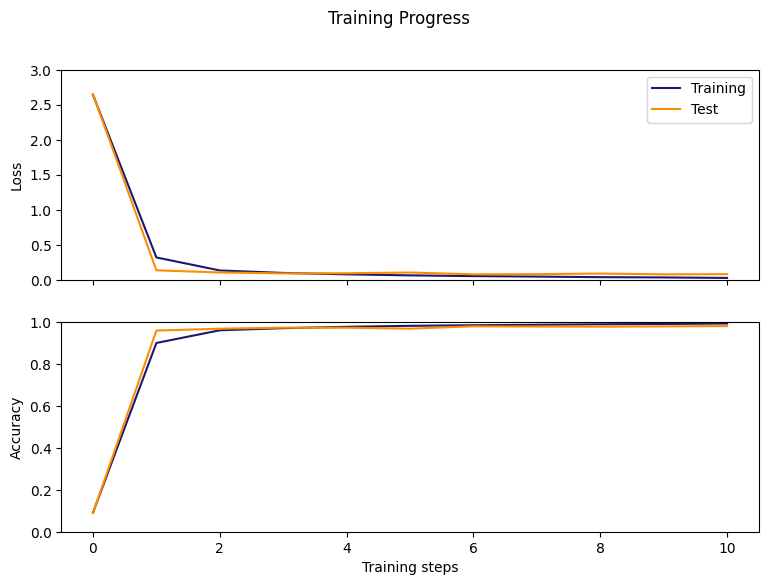

In [ ]:
# Show the losses and accuracies of our base model throughout the training process
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Remarks:**

Our base model achieves an accuracy of ~98% on both the training and test data, implying a very strong capability to classify the MNIST images.

### Adjusting hyperparameters of the model

#### Variation 1: Using only one hidden layer with 256 units

Epoch 1: starting with accuracy 0.06389776357827476
Epoch 2: starting with accuracy 0.9486821086261981
Epoch 3: starting with accuracy 0.9634584664536742
Epoch 4: starting with accuracy 0.9645567092651757
Epoch 5: starting with accuracy 0.9697484025559105
Epoch 6: starting with accuracy 0.9715455271565495
Epoch 7: starting with accuracy 0.9720447284345048
Epoch 8: starting with accuracy 0.9716453674121406
Epoch 9: starting with accuracy 0.9751397763578274
Epoch 10: starting with accuracy 0.9729432907348243


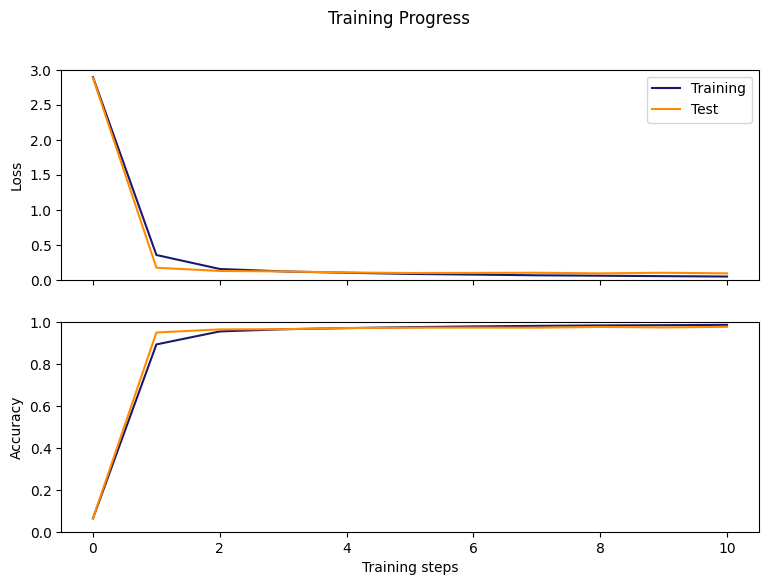

In [ ]:
tf.keras.backend.clear_session()

one_layer_model = MnistModel(n_hidden_layers=1)
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate)

train_losses, train_accuracies, test_losses, test_accuracies = training(one_layer_model, num_epochs, train_dataset, test_dataset, cross_entropy_loss, sgd_optimizer)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Remarks:**

When only using one hidden layer with the same number of neurons as the base model, the results show a similar accuracy on training and test data after ten epochs of training compared to the three-layer model.

#### Variation 2: Using only one hidden layer with 16 neurons

Epoch 1: starting with accuracy 0.09424920127795527
Epoch 2: starting with accuracy 0.6061301916932907
Epoch 3: starting with accuracy 0.6256988817891374
Epoch 4: starting with accuracy 0.6429712460063898
Epoch 5: starting with accuracy 0.7390175718849841
Epoch 6: starting with accuracy 0.702176517571885
Epoch 7: starting with accuracy 0.7403154952076677
Epoch 8: starting with accuracy 0.7228434504792333
Epoch 9: starting with accuracy 0.6700279552715654
Epoch 10: starting with accuracy 0.567991214057508


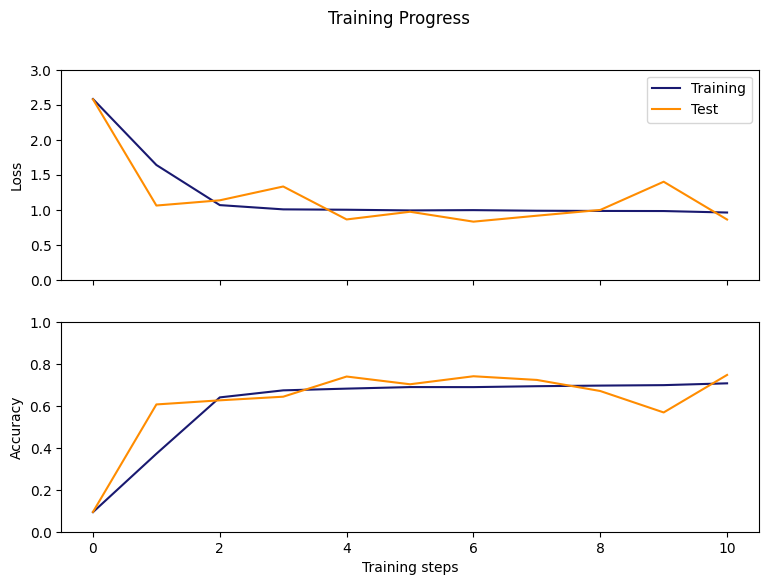

In [ ]:
tf.keras.backend.clear_session()

smaller_model = MnistModel(n_hidden_layers=1, hidden_layer_size=16)
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate)

train_losses, train_accuracies, test_losses, test_accuracies = training(smaller_model, num_epochs, train_dataset, test_dataset, cross_entropy_loss, sgd_optimizer)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Remarks:**

A smaller model with only 16 neurons in one hidden layer is not sufficient to achieve reliable image classification, since it only reaches about 70% accuracy after training.

#### Variation 3: Two hidden layers with 16 neurons each

Epoch 1: starting with accuracy 0.11132188498402557
Epoch 2: starting with accuracy 0.8840854632587859
Epoch 3: starting with accuracy 0.8888777955271565
Epoch 4: starting with accuracy 0.9129392971246006
Epoch 5: starting with accuracy 0.9125399361022364
Epoch 6: starting with accuracy 0.9251198083067093
Epoch 7: starting with accuracy 0.9299121405750799
Epoch 8: starting with accuracy 0.9289137380191693
Epoch 9: starting with accuracy 0.9108426517571885
Epoch 10: starting with accuracy 0.9202276357827476


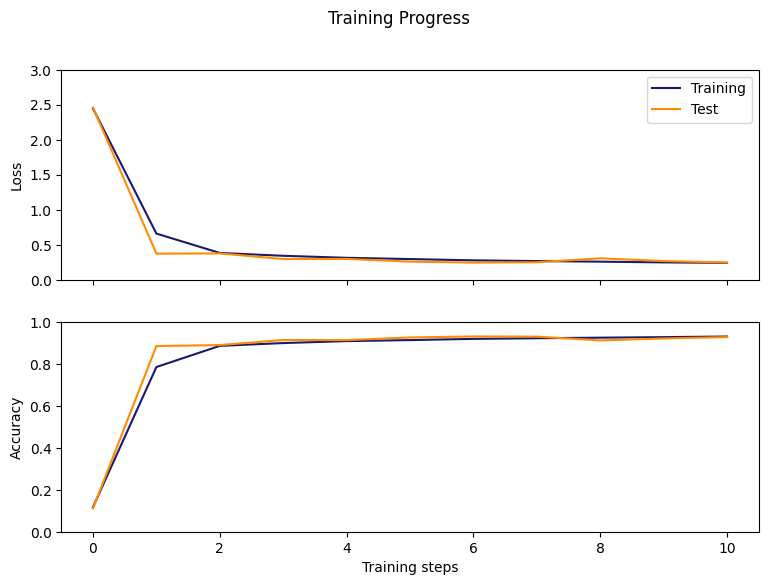

In [ ]:
tf.keras.backend.clear_session()

smaller_model = MnistModel(n_hidden_layers=2, hidden_layer_size=16)
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate)

train_losses, train_accuracies, test_losses, test_accuracies = training(smaller_model, num_epochs, train_dataset, test_dataset, cross_entropy_loss, sgd_optimizer)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Remarks:**

Adding another layer with 16 neurons to the previous variation significantly improves the model perfomance, reaching above 90% in training and test accuracy.

#### Variation 4: Tweaking the learning rate and momentum of the SGD optimizer

Epoch 1: starting with accuracy 0.09734424920127796
Epoch 2: starting with accuracy 0.9306110223642172
Epoch 3: starting with accuracy 0.9481829073482428
Epoch 4: starting with accuracy 0.9586661341853036
Epoch 5: starting with accuracy 0.9598642172523961
Epoch 6: starting with accuracy 0.9674520766773163
Epoch 7: starting with accuracy 0.9660543130990416
Epoch 8: starting with accuracy 0.9698482428115016
Epoch 9: starting with accuracy 0.9702476038338658
Epoch 10: starting with accuracy 0.9730431309904153


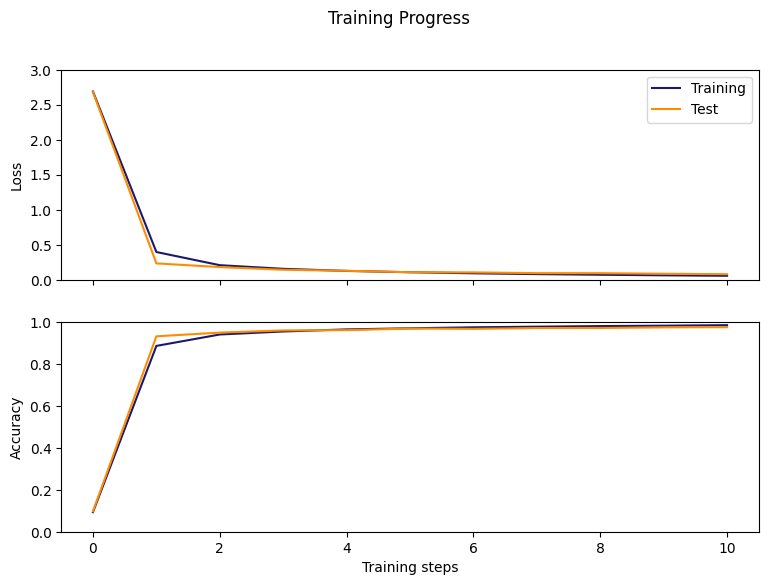

In [ ]:
tf.keras.backend.clear_session()

sgd_optimizer_2 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.3)
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
sgd_model = MnistModel()

train_losses, train_accuracies, test_losses, test_accuracies = training(sgd_model, num_epochs, train_dataset, test_dataset, cross_entropy_loss, sgd_optimizer_2)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Remarks:**

Applying a smaller learning rate of 0.01 and a momentum of 0.3 to the base model, we achieved similarly high results in terms of the model accuracy.

#### Variation 5: Smaller network combined with adjustments to SGD optimizer

Epoch 1: starting with accuracy 0.10383386581469649
Epoch 2: starting with accuracy 0.8940694888178914
Epoch 3: starting with accuracy 0.9041533546325878
Epoch 4: starting with accuracy 0.9114416932907349
Epoch 5: starting with accuracy 0.9183306709265175
Epoch 6: starting with accuracy 0.9127396166134185
Epoch 7: starting with accuracy 0.9168330670926518
Epoch 8: starting with accuracy 0.9183306709265175
Epoch 9: starting with accuracy 0.9218250798722045
Epoch 10: starting with accuracy 0.9153354632587859


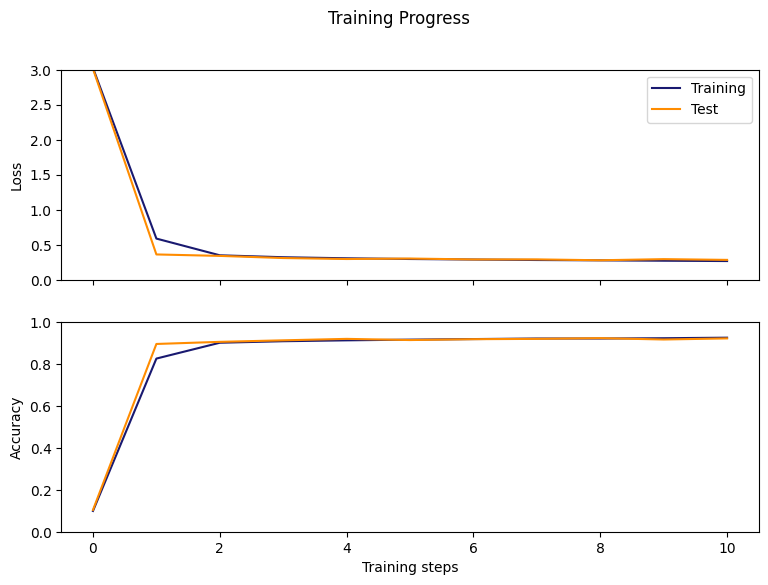

In [ ]:
tf.keras.backend.clear_session()

sgd_optimizer_3 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5)
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
smaller_model = MnistModel(n_hidden_layers=1, hidden_layer_size=16)

train_losses, train_accuracies, test_losses, test_accuracies = training(smaller_model, num_epochs, train_dataset, test_dataset, cross_entropy_loss, sgd_optimizer_3)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Remarks:**

Using a learning rate of 0.01 and an even higher momentum of 0.5, we could achieve ~92% accuracy on training and test data, while only using one hidden layer with 16 neurons. This is slightly below the base model, which had 16 times as many units in its hidden layers.